In [1]:
from dictionary_graph import DictionaryGraph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import issparse, csr_matrix
import networkx as nx
import time

In [2]:
# Projekcija vektora jedinica na dominantni potprostor nenegativne kvadratne matrice
def project1(M):
    w, V = np.linalg.eigh(M)
    p = np.full(w.shape, w[-1]) # Perronov korijen p
    P = V[:,np.isclose(w, p) | np.isclose(w, -p)] # Potprostori od p i -p
    Pi = P @ P.T # Projektor na potprostore
    return np.sum(Pi, 0) # Projekcija vektora jedinica na potprostore


# Računa matricu sličnosti grafova s matricama susjedstva A i B
# method: iterative ili projector
# - iterative: matrica sličnosti računa se iteriranjem
# - projector: matrica sličnosti računa se preko projektora, za nenegativne matrice A i B
# max_iter: maksimalan broj iteracija za method=iterative
# stop_early: zaustavlja iteriranje za method=iterative ako je norma razlike uzastopnih iteracija manja od epsilon
# epsilon: konstanta za stop_early=True
def similarity_matrix(A, B, method="iterative", max_iter=100, stop_early=True, epsilon=1e-6, store_iterations=None):
    if method == "iterative":
        Z = np.full((B.shape[0], A.shape[0]), 1, dtype=np.float64)
        AT = A.T
        BT = B.T
        for i in range(max_iter):
            Z2 = Z
            for j in range(2):
                Z = B @ Z @ AT + BT @ Z @ A
                Z /= np.linalg.norm(Z, 'fro')
            if store_iterations is not None:
                store_iterations.append(Z)
            if stop_early and np.linalg.norm(Z - Z2, np.inf) < epsilon:
                return Z
        if stop_early:
            print('Warning: stop_early conditions not met.')
        return Z
    elif method == "projector":
        if sparse.issparse(A):
            A = A.toarray()
        if issparse(B):
            B = B.toarray()
        Z = project1(np.kron(A, B) + np.kron(A.T, B.T))
        return Z.reshape((A.shape[0], B.shape[0])).T / np.linalg.norm(Z)


# Računa centralne scorove grafa s matricom susjedstva B
# Konačni vektor je normiran tako da mu 2-norma bude jednaka 1
def central_scores(B, method="iterative", **kwargs):
    if method == "theorem6":
        M = B.T @ B + B @ B.T
        if sparse.issparse(M):
            M = M.toarray()
        Z1 = project1(M)
    else:
        Z1 = similarity_matrix(
            np.array([
                [0, 1, 0],
                [0, 0, 1],
                [0, 0, 0],
            ], dtype=np.float64),
            B,
            method = method,
            **kwargs
        )[:,1]
    return Z1 / np.linalg.norm(Z1)

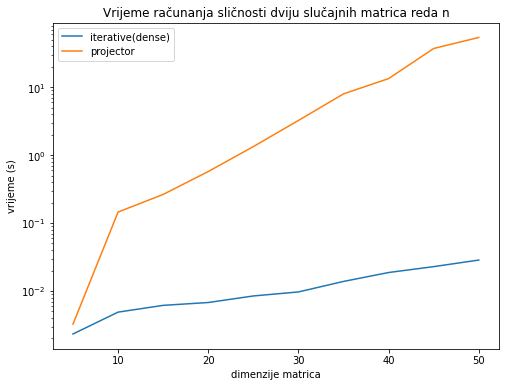

In [3]:
dimensions = list(range(5, 51, 5))
iterative = []
projector = []

np.random.seed(0)
for n in dimensions:
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)
    
    start = time.process_time()
    similarity_matrix(A, B, method="projector")
    projector.append(time.process_time() - start)
    
    start = time.process_time()
    similarity_matrix(A, B)
    iterative.append(time.process_time() - start)


plt.figure(figsize=(8, 6))
plt.plot(dimensions, iterative, label='iterative(dense)')
plt.plot(dimensions, projector, label='projector')
plt.legend()
plt.title('Vrijeme računanja sličnosti dviju slučajnih matrica reda n')
plt.xlabel('dimenzije matrica')
plt.ylabel('vrijeme (s)')
plt.yscale('log')
plt.show()

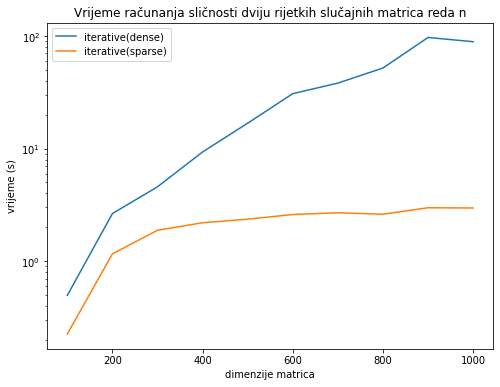

In [4]:
# random matrica nxn s m elemenata različitih od 0
def random_matrix(n, m):
    m = min(m, n**2)
    return np.random.permutation(np.pad(np.random.rand(m), (0, n**2 - m))).reshape((n, n))

dimensions = list(range(100, 1001, 100))
iterative_dense = []
iterative_sparse = []

np.random.seed(0)
for n in dimensions:
    A = random_matrix(n, 5*n)
    B = random_matrix(n, 5*n)
    
    start = time.process_time()
    similarity_matrix(A, B)
    iterative_dense.append(time.process_time() - start)
    
    A = csr_matrix(A)
    B = csr_matrix(B)
    start = time.process_time()
    similarity_matrix(A, B)
    iterative_sparse.append(time.process_time() - start)


plt.figure(figsize=(8, 6))
plt.plot(dimensions, iterative_dense, label='iterative(dense)')
plt.plot(dimensions, iterative_sparse, label='iterative(sparse)')
plt.legend()
plt.title('Vrijeme računanja sličnosti dviju rijetkih slučajnih matrica reda n')
plt.xlabel('dimenzije matrica')
plt.ylabel('vrijeme (s)')
plt.yscale('log')
plt.show()

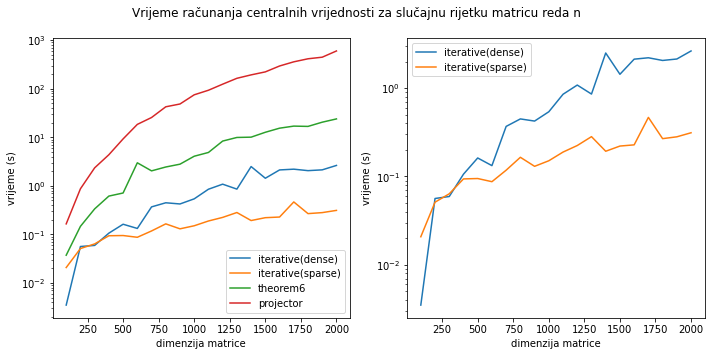

In [5]:
dimensions = list(range(100, 2001, 100))
sample_size=1
iterative_dense = [0]*len(dimensions)
iterative_sparse = [0]*len(dimensions)
theorem6 = [0]*len(dimensions)
projector = [0]*len(dimensions)

np.random.seed(0)
for i in range(len(dimensions)):
    B = random_matrix(dimensions[i], 5*dimensions[i])
    
    for _ in range(sample_size):
        start = time.process_time()
        t1 = central_scores(B)
        iterative_dense[i] += (time.process_time() - start) / sample_size

        start = time.process_time()
        central_scores(B, method='projector')
        projector[i] += (time.process_time() - start) / sample_size

        B = csr_matrix(B)
        
        start = time.process_time()
        central_scores(B, method='theorem6')
        theorem6[i] += (time.process_time() - start) / sample_size

        start = time.process_time()
        t2 = central_scores(B)
        iterative_sparse[i] += (time.process_time() - start) / sample_size
        

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Vrijeme računanja centralnih vrijednosti za slučajnu rijetku matricu reda n')
plt.subplot(1, 2, 1)
plt.plot(dimensions, iterative_dense, label='iterative(dense)')
plt.plot(dimensions, iterative_sparse, label='iterative(sparse)')
plt.plot(dimensions, theorem6, label='theorem6')
plt.plot(dimensions, projector, label='projector')
plt.legend()
plt.xlabel('dimenzija matrice')
plt.ylabel('vrijeme (s)')
plt.yscale('log')
plt.subplot(1, 2, 2)
plt.plot(dimensions, iterative_dense, label='iterative(dense)')
plt.plot(dimensions, iterative_sparse, label='iterative(sparse)')
plt.legend()
plt.xlabel('dimenzija matrice')
plt.ylabel('vrijeme (s)')
plt.yscale('log')
plt.tight_layout()

In [6]:
graph = DictionaryGraph('OPTED')
print('Broj vrhova: {}\nBroj bridova: {}'.format(*graph.size()))

Broj vrhova: 106282
Broj bridova: 1315090


In [7]:
print('Riječi s najvećim ulaznim stupnjem')
graph.vertices().join(graph.indegrees(), how='inner').set_index('value')['indegree'].nlargest(15)

Riječi s najvećim ulaznim stupnjem


value
of       64580
a        44335
the      40988
or       39210
to       30408
in       22386
as       21216
and      15445
an       13147
one      11500
by       11467
with     10184
which     9816
is        7896
see       7706
Name: indegree, dtype: int64

In [8]:
def get_synonyms(word, n=10, **kwargs):
    vertices, adjacency_matrix = graph.neighbourhood(word, **kwargs)
    return pd.Series(central_scores(adjacency_matrix), index=vertices).nlargest(n)

In [9]:
word = input('Upiši riječ: ')
methods = [(1, None), (2, None), (3, lambda x: x), (3, np.sqrt)]
for i in range(len(methods)):
    print(f'Metoda {i + 1}')
    print(get_synonyms(word, method=methods[i][0], f=methods[i][1]), end='\n\n')

Upiši riječ: disappear
Metoda 1
value
to           0.305198
as           0.300769
a            0.287973
or           0.284463
of           0.277002
the          0.257437
disappear    0.225468
be           0.212517
from         0.204452
at           0.172435
dtype: float64

Metoda 2
value
disappear    0.671406
vanish       0.347526
pass         0.297825
die          0.215795
fade         0.188881
wear         0.179517
faint        0.177947
sail         0.159799
gradually    0.155742
light        0.120907
dtype: float64

Metoda 3
value
evanid         0.999192
vanish         0.026610
disappear      0.026220
faint          0.013018
fade           0.002795
die            0.002575
pass           0.002332
dissipate      0.002317
evanesce       0.002315
disappeared    0.001388
dtype: float64

Metoda 4
value
evanid       0.722215
disappear    0.461294
vanish       0.306666
faint        0.184438
fade         0.174102
die          0.126456
pass         0.110512
eliminate    0.100482
dissipate    

In [10]:
def display_synonyms(word, n=10, subgraph=True, **kwargs):
    vertices, adjacency_matrix = graph.neighbourhood(word, **kwargs)
    synonyms = get_synonyms(word, n=n, **kwargs)
    labels = pd.Series(vertices.index, index=vertices.values)
    A = adjacency_matrix.toarray()
    g = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph())
    if subgraph: # podgraf samo sa sinonimima
        indices = list(synonyms.index.map(pd.Series(vertices.index, vertices)))
        g = g.subgraph(indices)
        labels = pd.Series(synonyms.index, index=indices).to_dict()
    else:
        labels = vertices.to_dict()
    print(synonyms)
    plt.figure(figsize=(8,8))
    nx.draw(
        g,
        pos=nx.circular_layout(g),
        with_labels=True,
        labels=labels,
        node_size=6000,
        node_color='white',
        edgecolors='black',
    )

Upiši riječ: evanid
value
faint         0.483475
evanid        0.480967
vanish        0.426350
weak          0.332594
evanescent    0.326005
disappear     0.303391
liable        0.210249
dtype: float64


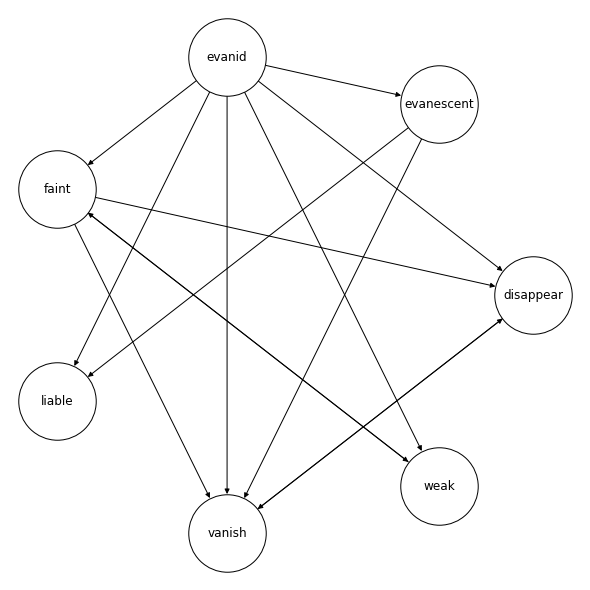

In [11]:
word = input('Upiši riječ: ')
display_synonyms(word, method=2, subgraph=True)